In [1]:
 import numpy as np

In [2]:
from numba import jit

In [3]:
from scipy import integrate

In [4]:
import numpy as np
from numba import jit

@jit(nopython=True)
def Numerov(f,u,x0,dx,h):
    """calculate the second order linear differential equation:
    x''(t)=f(t)x(t)+u(t),
    the input f,u are 1D array in numpy, they must be the same length.
    x0 = x(t=0), and dx = dx/dt(t=0)
    h is the spacing of t, the grid need be equal-spaced.
    """     
    x=np.zeros(len(f))
    
    x[0]=x0
    x[1]=x0+dx*h
    h2=h*h
    h12=h2/12
    w0=x[0]*(1-h12*f[0])-h12*u[0]
    w1=x[1]*(1-h12*f[1])-h12*u[1]

    for i in range(2,len(f)):
        w2=2*w1-w0+h2*f[i-1]*x[i-1]+u[i-1]*h2
        x[i]=(w2+h12*u[i])/(1-h12*f[i])
        (w0,w1)=(w1,w2)
              
    return x

In [5]:
def get_f(l,r,E,V_KS):
    """
    r must be array in numpy
    """
    return l*(l+1)/r**2+V_KS-E

In [6]:
def get_u(l,r,E,V_KS):
    """
    """
    f=get_f(l,r,E,V_KS)[::-1]
    u=Numerov(f,np.zeros(len(f)),0,-1e-7,r[1]-r[0])[::-1]
    norm = integrate.simpson(u**2, x=r)
    return u/np.sqrt(abs(norm))

插值的个数或许可以改变，调节，有数据之后可以尝试

In [7]:
from scipy import interpolate
#help(interpolate.UnivariateSpline)
def get_approx_u_0(E,l,r,V_KS):
    """
    """
    u=get_u(l,r,E,V_KS)
    spl=interpolate.UnivariateSpline(r[:4],u[:4],k=3,s=0)
    u_0=spl(0)
    return u_0

In [8]:
from scipy import optimize
#help(optimize.brentq)

def get_bound_state(E_range,l,V_KS,r,num_max):
    """
    """
    band=[]
    u_0=get_approx_u_0(E_range[0],l,r,V_KS)
    for i in range(1,len(E_range)):
        u_1=get_approx_u_0(E_range[i],l,r,V_KS)
        if u_0*u_1<0:
            Ebound = optimize.brentq(get_approx_u_0,E_range[i-1],E_range[i],
                                     xtol=1e-15,rtol=1e-10,args=(l,r,V_KS)) 
            band.append((l,Ebound))
            print("Find the bound state with l=%d, energy(Ry)=%14.9f, energy(Hartree)=%14.9f"%(l,Ebound,Ebound/2))
        u_0=u_1
        if(len(band)>=num_max):
            break
    band=sorted(band, key=lambda x:x[1]+x[0]/1e4)
    return band

In [9]:

def electron_dendity(band,Z,r,V_KS):
    """
    """
    N=0
    
    rho=np.zeros(len(r))
    E_band=0
    for (l,Ebound) in band:
        u=get_u(l,r,Ebound,V_KS)
        if(N+(2*l+1)*2<Z):
            occup=1.
            N=N+(2*l+1)*2
            print("add %d electron in bound state l=%d E(Ry)=%14.9f E(Hartree)=%14.9f N=%d"%(2*(2*l+1),l,Ebound,Ebound/2,N))
            rho=rho+2*(2*l+1)*u**2/(4*np.pi*r**2)
            E_band+=Ebound*2*(2*l+1)
        else:
            occup=(Z-N)/(2*l+1)/2
            N=Z
            print("add %d electron in bound state l=%d E(Ry)=%14.9f E(Hartree)=%14.9f N=%d"%(occup*(2*l+1)*2,l,Ebound,Ebound/2,N))     
            rho=rho+occup*(2*l+1)*2*u**2/(4*np.pi*r**2)
            E_band+=Ebound*2*(2*l+1)*occup
            break
    return rho,E_band
            

In [10]:
def V_Hartree(rho,r,Z):
    """
    """
    u=-8*np.pi*r*rho
    U_pois=Numerov(np.zeros(len(u)),u,0,0.5,r[1]-r[0])
    alpha=(2*Z-U_pois[-1])/r[-1]
    U_pois=U_pois+alpha*r
    return U_pois/r

In [11]:
@jit(nopython=True)
def rs(rho):
    """
    1/rho = 4*pi*rs^3/3 => rs = (3/(4*pi*rho))**(1/3.)"""
    ""
    if rho < 1e-100: return 1e100  #avoid overflow
    return (3/(4*np.pi*rho))**(1/3)

In [12]:
from excor import ExchangeCorrelation
exc = ExchangeCorrelation()
#the above file uses the Hartree atomic unit, so we need to multiply 2.
def V_xc(rho):
    """
    """
    
    Vxc = [2*exc.Vc(rs(i)) + 2*exc.Vx(rs(i)) for i in rho]
    return Vxc
  

In [13]:
def U_KS(rho,U_hartree,r,Z):
    """
    """
    return U_hartree - 2*Z/r + V_xc(rho)

In [14]:
def E_total(rho,E_band,r,Z):
    """
    """
    E_total=E_band
    energy_density=-V_Hartree(rho,r,Z)/2
    ExcVxc = [2*exc.EcVc(rs(i)) + 2*exc.ExVx(rs(i)) for i in rho]  
    energy_density=(ExcVxc-V_Hartree(rho,r,Z)/2)*4*np.pi*r**2*rho
    E2=integrate.simpson(energy_density,x=r)
    E_total+=E2
    return E_total

In [15]:
from pyinstrument import Profiler
profiler=Profiler()

In [16]:
import matplotlib.pyplot as plt

Find the bound state with l=0, energy(Ry)=  -1.777933901, energy(Hartree)=  -0.888966950
Find the bound state with l=0, energy(Ry)=  -1.605215824, energy(Hartree)=  -0.802607912
Find the bound state with l=0, energy(Ry)=  -1.383149725, energy(Hartree)=  -0.691574862
Find the bound state with l=1, energy(Ry)=  -1.949523179, energy(Hartree)=  -0.974761589
Find the bound state with l=1, energy(Ry)=  -1.850801210, energy(Hartree)=  -0.925400605
add 6 electron in bound state l=1 E(Ry)=  -1.949523179 E(Hartree)=  -0.974761589 N=6
add 2 electron in bound state l=1 E(Ry)=  -1.850801210 E(Hartree)=  -0.925400605 N=8
The number of electrons is 8.00 
Itteration 0 Etot[Ry]= -19.990079330372073 Etot[Hartre]= -9.995039665186036 Diff= 19.990079330372073
Find the bound state with l=0, energy(Ry)= -62.456899970, energy(Hartree)= -31.228449985
Find the bound state with l=0, energy(Ry)= -14.507306869, energy(Hartree)=  -7.253653435
Find the bound state with l=0, energy(Ry)=  -5.671691342, energy(Hartree)

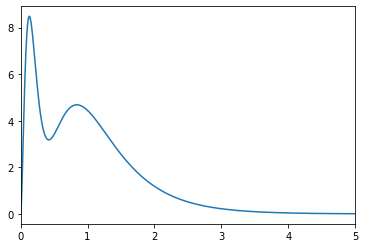


  _     ._   __/__   _ _  _  _ _/_   Recorded: 00:50:35  Samples:  33246
 /_//_/// /_\ / //_// / //_'/ //     Duration: 34.538    CPU time: 33.438
/   _/                      v4.0.3

Program: /home/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-eb117585-2cae-4c32-a96f-ace3237f4738.json

34.538 run_ast_nodes  IPython/core/interactiveshell.py:3249
└─ 34.534 run_code  IPython/core/interactiveshell.py:3400
   ├─ 33.944 <module>  ../../tmp/ipykernel_4462/1027806441.py:16
   │  ├─ 15.073 U_KS  ../../tmp/ipykernel_4462/1636620910.py:1
   │  │  └─ 15.008 V_xc  ../../tmp/ipykernel_4462/3269175940.py:4
   │  │     └─ 15.008 <listcomp>  ../../tmp/ipykernel_4462/3269175940.py:8
   │  │        ├─ 7.677 Vc  excor.py:54
   │  │        │  ├─ 4.615 [self]  
   │  │        │  ├─ 1.534 log  <built-in>:0
   │  │        │  │     [2 frames hidden]  <built-in>
   │  │        │  ├─ 0.776 atan  <built-in>:0
   │  │        │  │     [2 frames hidden]  <b

In [17]:
profiler.start()
R = np.linspace(1e-8,20,2**14+1)
Z = 8
mixr = 0.5

E0=-1.2*Z**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
E_range = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
num_max=3

exc = ExchangeCorrelation()
V_KS = -2*np.ones(len(R))
E_old = 0
Etol = 1e-7

for itt in range(100):
    band=[]
    for l in range(num_max-1):
        band.extend(get_bound_state(E_range,l,V_KS,R,num_max-l))
    band=sorted(band, key=lambda x:x[1]+x[0]/1e4)
    rho_new,E_band=electron_dendity(band,Z,R,V_KS)

    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = rho.copy()
    
    U_hartree =  V_Hartree(rho, R, Z) 

    V_KS=U_KS(rho,U_hartree,R,Z)
    
    E_tot=E_total(rho,E_band,R,Z)
    
    print('The number of electrons is %.2f '%( integrate.simpson(rho*(4*np.pi*R**2),x=R)))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', E_tot, 'Etot[Hartre]=', E_tot/2, 'Diff=', abs(E_tot-E_old))

    
    if  itt>0 and abs(E_tot-E_old)< Etol: break
    E_old = E_tot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()

plt.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])
plt.show()    
profiler.stop()
profiler.print()